# German Traffic Sign Classification

---

In [2]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import tensorflow as tf

---

## Dataset

In [3]:
import pickle

def load_pickled_data(file, columns):
    """
    Loads pickled training and test data.
    
    Parameters
    ----------
    file    : 
              Name of the pickle file.
    columns : list of strings
              List of columns in pickled data we're interested in.

    Returns
    -------
    A tuple of datasets for given columns.    
    """

    with open(file, mode='rb') as f:
        dataset = pickle.load(f)
    return tuple(map(lambda c: dataset[c], columns))

In [4]:
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]
train_dataset_file = "traffic-signs-data/train.p"
test_dataset_file = "traffic-signs-data/test.p"
train_balanced_dataset_file = "traffic-signs-data/train_balanced.p"

X_train, y_train = load_pickled_data(train_dataset_file, ['features', 'labels'])
X_test, y_test = load_pickled_data(test_dataset_file, ['features', 'labels'])

n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape
image_size = image_shape[0]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

FileNotFoundError: [Errno 2] No such file or directory: 'traffic-signs-data/train.p'

Go through all dataset classes, noting number of samples and plotting 10 random images representing each class.

In [1]:
import random

col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("Class %i: %-*s  %s samples" % (c, col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print("--------------------------------------------------------------------------------------\n")
    
pyplot.bar( np.arange( 43 ), class_counts, align='center' )
pyplot.xlabel('Class')
pyplot.ylabel('Number of training examples')
pyplot.xlim([-1, 43])
pyplot.show()

NameError: name 'signnames' is not defined

Some classes are highly underrepresented. Overall amount of data is disappointing: some classes have as little as 210 samples, this won't be enough for most of the models to generalise well.

Images with some signs are horizontally and/or vertically symmetrical (like **Bumpy road** or **Ahead only**), and can be simply flipped, thus allowing us to get twice as much data for these classes. 

Other signs come in kind of interchageable pairs, like **Keep right** and **Keep left**: those signs can be flipped and assigned to a paired class. In some cases (like **Keep right** and **Keep left**) we increase the number of samples for **Keep left** from 300 to 2370!

CNNs have built-in invariance to small translations, scaling and rotations. The training set doesn't seem to contain those deformations, so we will add those in our data augmentation step as well.

----

## Model Architecture

Some useful logging routines.

In [4]:
import sys
import time

def get_time_hhmmss(start = None):
    """
    Calculates time since `start` and formats as a string.
    """
    if start is None:
        return time.strftime("%Y/%m/%d %H:%M:%S")
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str   

# Print iterations progress
def print_progress(iteration, total):
    """
    Call in a loop to create terminal progress bar
    
    Parameters
    ----------
        
    iteration : 
                Current iteration (Int)
    total     : 
                Total iterations (Int)
    """
    str_format = "{0:.0f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(100 * iteration / float(total)))
    bar = '█' * filled_length + '-' * (100 - filled_length)

    sys.stdout.write('\r |%s| %s%%' % (bar, percents)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

Preprocessing routines.

In [5]:
from sklearn.utils import shuffle
from skimage import exposure
import warnings 

num_classes = 43

def preprocess_dataset(X, y = None):
    """
    Performs feature scaling, one-hot encoding of labels and shuffles the data if labels are provided.
    Assumes original dataset is sorted by labels.
    
    Parameters
    ----------
    X                : ndarray
                       Dataset array containing feature examples.
    y                : ndarray, optional, defaults to `None`
                       Dataset labels in index form.
    Returns
    -------
    A tuple of X and y.    
    """
    print("Preprocessing dataset with {} examples:".format(X.shape[0]))

    #Convert to grayscale, e.g. single channel Y
    X = 0.299 * X[:, :, :, 0] + 0.587 * X[:, :, :, 1] + 0.114 * X[:, :, :, 2]
    #Scale features to be in [0, 1]
    X = (X / 255.).astype(np.float32)
        
    for i in range(X.shape[0]):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            X[i] = exposure.equalize_adapthist(X[i])
        print_progress(i + 1, X.shape[0])
        
    if y is not None:  
        # Convert to one-hot encoding. Convert back with `y = y.nonzero()[1]`
        y = np.eye(num_classes)[y]
        X, y = shuffle(X, y)

    # Add a single grayscale channel
    X = X.reshape(X.shape + (1,)) 
    return X, y

def class_name(one_hot):
    return signnames[one_hot.nonzero()[0][0]]

def load_and_process_data(pickled_data_file):
    """
    Loads pickled data and preprocesses images and labels by scaling features, 
    shuffling the data and applying one-hot encoding to labels.
    
    Parameters
    ----------
    pickled_data_file  : string
                         Pickled data file name.
    Returns
    -------
    A tuple of X and y containing preloaded and preprocessed features and labels respectively.    
    """
    X, y = load_pickled_data(pickled_data_file, columns = ['features', 'labels'])
    X, y = preprocess_dataset(X, y)
    return (X, y)

Data augmentation.

In [ ]:
from nolearn.lasagne import BatchIterator
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import random

class AugmentedSignsBatchIterator(BatchIterator):
    """
    Iterates over dataset in batches. 
    Allows images augmentation by randomly rotating, applying projection, 
    adjusting gamma, blurring, adding noize and flipping horizontally.
    """
        
    def __init__(self, batch_size, shuffle = False, seed = 42, p = 0.5, intensity = 0.5):
        """
        Initialises an instance with usual iterating settings, as well as data augmentation coverage
        and augmentation intensity.
        
        Parameters
        ----------
        batch_size:
                    Size of the iteration batch.
        shuffle   :
                    Flag indicating if we need to shuffle the data.
        seed      :
                    Random seed.
        p         :
                    Probability of augmenting a single example, should be in a range of [0, 1] .
                    Defines data augmentation coverage.
        intensity :
                    Augmentation intensity, should be in a [0, 1] range.
        
        Returns
        -------
        New batch iterator instance.
        """
        super(AugmentedSignsBatchIterator, self).__init__(batch_size, shuffle, seed)
        self.p = p
        self.intensity = intensity

    def transform(self, Xb, yb):
        """
        Applies a pipeline of randomised transformations for data augmentation.
        """
        Xb, yb = super(AugmentedSignsBatchIterator, self).transform(
            Xb if yb is None else Xb.copy(), 
            yb
        )
        
        if yb is not None:
            batch_size = Xb.shape[0]
            image_size = Xb.shape[1]
            
            Xb = self.rotate(Xb, batch_size)
            Xb = self.apply_projection_transform(Xb, batch_size, image_size)

        return Xb, yb
        
    def rotate(self, Xb, batch_size):
        """
        Applies random rotation in a defined degrees range to a random subset of images. 
        Range itself is subject to scaling depending on augmentation intensity.
        """
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):
            delta = 30. * self.intensity # scale by self.intensity
            Xb[i] = rotate(Xb[i], random.uniform(-delta, delta), mode = 'edge')
        return Xb   
    
    def apply_projection_transform(self, Xb, batch_size, image_size):
        """
        Applies projection transform to a random subset of images. Projection margins are randomised in a range
        depending on the size of the image. Range itself is subject to scaling depending on augmentation intensity.
        """
        d = image_size * 0.3 * self.intensity
        for i in np.random.choice(batch_size, int(batch_size * self.p), replace = False):        
            tl_top = random.uniform(-d, d)     # Top left corner, top margin
            tl_left = random.uniform(-d, d)    # Top left corner, left margin
            bl_bottom = random.uniform(-d, d)  # Bottom left corner, bottom margin
            bl_left = random.uniform(-d, d)    # Bottom left corner, left margin
            tr_top = random.uniform(-d, d)     # Top right corner, top margin
            tr_right = random.uniform(-d, d)   # Top right corner, right margin
            br_bottom = random.uniform(-d, d)  # Bottom right corner, bottom margin
            br_right = random.uniform(-d, d)   # Bottom right corner, right margin

            transform = ProjectiveTransform()
            transform.estimate(np.array((
                    (tl_left, tl_top),
                    (bl_left, image_size - bl_bottom),
                    (image_size - br_right, image_size - br_bottom),
                    (image_size - tr_right, tr_top)
                )), np.array((
                    (0, 0),
                    (0, image_size),
                    (image_size, image_size),
                    (image_size, 0)
                )))
            Xb[i] = warp(Xb[i], transform, output_shape=(image_size, image_size), order = 1, mode = 'edge')

        return Xb

Let's test data augmentation by plotting first 5 examples next to the original images (original image is on the left).

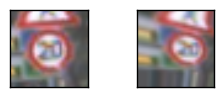

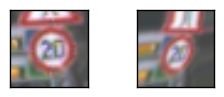

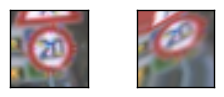

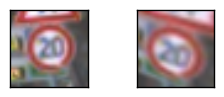

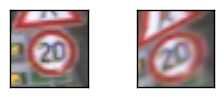

In [22]:
X_train, y_train = load_pickled_data("traffic-signs-data/train.p", columns = ['features', 'labels'])
X_train = X_train / 255.

batch_iterator = AugmentedSignsBatchIterator(batch_size = 5, p = 1.0, intensity = 0.75)
for x_batch, y_batch in batch_iterator(X_train, y_train):
    for i in range(5): 
        # plot two images:
        fig = pyplot.figure(figsize=(3, 1))
        axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        axis.imshow(X_train[i])
        axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        axis.imshow(x_batch[i])
        pyplot.show()
    break

A couple of functions for preprocessing our dataset. We may only need to call them once, then pickle resulting balanced dataset and keep using that pickle from then on.

In [7]:
def flip_extend(X, y):
    """
    Extends existing images dataset by flipping images of some classes. As some images would still belong
    to same class after flipping we extend such classes with flipped images. Images of other would toggle 
    between two classes when flipped, so for those we extend existing datasets as well.
    
    Parameters
    ----------
    X       : ndarray
              Dataset array containing feature examples.
    y       : ndarray, optional, defaults to `None`
              Dataset labels in index form.

    Returns
    -------
    A tuple of X and y.    
    """
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = y.dtype)
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype = int))
    
    return (X_extended, y_extended)

def extend_balancing_classes(X, y, aug_intensity = 0.5, counts = None):
    """
    Extends dataset by duplicating existing images while applying data augmentation pipeline.
    Number of generated examples for each class may be provided in `counts`.
    
    Parameters
    ----------
    X             : ndarray
                    Dataset array containing feature examples.
    y             : ndarray, optional, defaults to `None`
                    Dataset labels in index form.
    aug_intensity :
                    Intensity of augmentation, must be in [0, 1] range.
    counts        :
                    Number of elements for each class.
                    
    Returns
    -------
    A tuple of X and y.    
    """
    num_classes = 43

    _, class_counts = np.unique(y, return_counts = True)
    max_c = max(class_counts)
    total = max_c * num_classes if counts is None else np.sum(counts)
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = np.float32)
    y_extended = np.empty([0], dtype = y.dtype)
    print("Extending dataset using augmented data (intensity = {}):".format(aug_intensity))
    
    for c, c_count in zip(range(num_classes), class_counts):
        # How many examples should there be eventually for this class:
        max_c = max_c if counts is None else counts[c]
        # First copy existing data for this class
        X_source = (X[y == c] / 255.).astype(np.float32)
        y_source = y[y == c]
        X_extended = np.append(X_extended, X_source, axis = 0)
        for i in range((max_c // c_count) - 1):
            batch_iterator = AugmentedSignsBatchIterator(batch_size = X_source.shape[0], p = 1.0, intensity = aug_intensity)
            for x_batch, _ in batch_iterator(X_source, y_source):
                X_extended = np.append(X_extended, x_batch, axis = 0)
                print_progress(X_extended.shape[0], total)
        batch_iterator = AugmentedSignsBatchIterator(batch_size = max_c % c_count, p = 1.0, intensity = aug_intensity)
        for x_batch, _ in batch_iterator(X_source, y_source):
            X_extended = np.append(X_extended, x_batch, axis = 0)
            print_progress(X_extended.shape[0], total)
            break
        # Fill labels for added images set to current class.
        added = X_extended.shape[0] - y_extended.shape[0]
        y_extended = np.append(y_extended, np.full((added), c, dtype = int))
        
    return ((X_extended * 255.).astype(np.uint8), y_extended)

Struct to organise some of the model parameters.

In [6]:
from collections import namedtuple

Parameters = namedtuple('Parameters', [
        # Data parameters
        'num_classes', 'image_size', 
        # Training parameters
        'batch_size', 'max_epochs', 'log_epoch', 'print_epoch',
        # Optimisations
        'learning_rate_decay', 'learning_rate',
        'l2_reg_enabled', 'l2_lambda', 
        'early_stopping_enabled', 'early_stopping_patience', 
        'resume_training', 
        # Layers architecture
        'conv1_k', 'conv1_d', 'conv1_p', 
        'conv2_k', 'conv2_d', 'conv2_p', 
        'conv3_k', 'conv3_d', 'conv3_p', 
        'fc4_size', 'fc4_p'
    ])

General routine for managing model paths, scopes and identifiers.

In [7]:
import os

class Paths(object):
    """
    Provides easy access to common paths we use for persisting 
    the data associated with model training.
    """
    
    def __init__(self, params):
        """
        Initialises a new `Paths` instance and creates corresponding folders if needed.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
        """
        self.model_name = self.get_model_name(params)
        self.var_scope = self.get_variables_scope(params)
        self.root_path = os.getcwd() + "/models/" + self.model_name + "/"
        self.model_path = self.get_model_path()
        self.train_history_path = self.get_train_history_path()
        self.learning_curves_path = self.get_learning_curves_path()
        os.makedirs(self.root_path, exist_ok = True)

    def get_model_name(self, params):
        """
        Generates a model name with some of the crucial model parameters encoded into the name.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
                  
        Returns
        -------
        Model name.
        """
        # We will encode model settings in its name: architecture, optimisations applied, etc.
        model_name = "k{}d{}p{}_k{}d{}p{}_k{}d{}p{}_fc{}p{}".format(
            params.conv1_k, params.conv1_d, params.conv1_p, 
            params.conv2_k, params.conv2_d, params.conv2_p, 
            params.conv3_k, params.conv3_d, params.conv3_p, 
            params.fc4_size, params.fc4_p
        )
        model_name += "_lrdec" if params.learning_rate_decay else "_no-lrdec"
        model_name += "_l2" if params.l2_reg_enabled else "_no-l2"
        return model_name

    def get_variables_scope(self, params):
        """
        Generates a model variable scope with some of the crucial model parameters encoded.

        Parameters
        ----------
        params  : Parameters
                  Structure (`namedtuple`) containing model parameters.
                  
        Returns
        -------
        Variables scope name.
        """
        # We will encode model settings in its name: architecture, optimisations applied, etc.
        var_scope = "k{}d{}_k{}d{}_k{}d{}_fc{}_fc0".format(
            params.conv1_k, params.conv1_d,
            params.conv2_k, params.conv2_d,
            params.conv3_k, params.conv3_d, 
            params.fc4_size
        )
        return var_scope

    def get_model_path(self):
        """
        Generates path to the model file.
   
        Returns
        -------
        Model file path.
        """
        return self.root_path + "model.ckpt"

    def get_train_history_path(self):
        """
        Generates path to the train history file.
   
        Returns
        -------
        Train history file path.
        """
        return self.root_path + "train_history"
    
    def get_learning_curves_path(self):
        """
        Generates path to the learning curves graph file.
   
        Returns
        -------
        Learning curves file path.
        """
        return self.root_path + "learning_curves.png"

Early stopping.

In [8]:
class EarlyStopping(object):
    """
    Provides early stopping functionality. Keeps track of model accuracy, 
    and if it doesn't improve over time restores last best performing 
    parameters.
    """
    
    def __init__(self, saver, session, patience = 100, minimize = True):
        """
        Initialises a `EarlyStopping` isntance.

        Parameters
        ----------
        saver     : 
                    TensorFlow Saver object to be used for saving and restoring model.
        session   : 
                    TensorFlow Session object containing graph where model is restored.
        patience  : 
                    Early stopping patience. This is the number of epochs we wait for 
                    accuracy to start improving again before stopping and restoring 
                    previous best performing parameters.
                  
        Returns
        -------
        New instance.
        """
        self.minimize = minimize
        self.patience = patience
        self.saver = saver
        self.session = session
        self.best_monitored_value = np.inf if minimize else 0.
        self.best_monitored_epoch = 0
        self.restore_path = None

    def __call__(self, value, epoch):
        """
        Checks if we need to stop and restores the last well performing values if we do.

        Parameters
        ----------
        value     : 
                    Last epoch monitored value.
        epoch     : 
                    Last epoch number.
                  
        Returns
        -------
        `True` if we waited enough and it's time to stop and we restored the 
        best performing weights, or `False` otherwise.
        """
        if (self.minimize and value < self.best_monitored_value) or (not self.minimize and value > self.best_monitored_value):
            self.best_monitored_value = value
            self.best_monitored_epoch = epoch
            self.restore_path = self.saver.save(self.session, os.getcwd() + "/early_stopping_checkpoint")
        elif self.best_monitored_epoch + self.patience < epoch:
            if self.restore_path != None:
                self.saver.restore(self.session, self.restore_path)
            else:
                print("ERROR: Failed to restore session")
            return True
        
        return False

Logger to keep track of the training even if no browser is connected to kernel.

In [9]:
from cloudlog import CloudLog

class ModelCloudLog(CloudLog):
        
    def log_parameters(self, params, train_size, valid_size, test_size):
        """
        Logs model parameters to console and appends the same text representation to the log file.

        Parameters
        ----------
        params    : Parameters
                    Structure (`namedtuple`) containing model parameters.
        train_size: int
                    Size of the training dataset.
        valid_size: int
                    Size of the training dataset.
        test_size : int
                    Size of the training dataset.
        """
        if params.resume_training:
            self("=============================================")
            self("============= RESUMING TRAINING =============")
            self("=============================================")

        self("=================== DATA ====================")
        self("            Training set: {} examples".format(train_size))
        self("          Validation set: {} examples".format(valid_size))
        self("             Testing set: {} examples".format(test_size))
        self("              Batch size: {}".format(params.batch_size))   

        self("=================== MODEL ===================")
        self("--------------- ARCHITECTURE ----------------")  
        self(" %-*s %-*s %-*s %-*s" % (10, "", 10, "Type", 8, "Size", 15, "Dropout (keep p)"))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 1", 10, "{}x{} Conv".format(params.conv1_k, params.conv1_k), 8, str(params.conv1_d), 15, str(params.conv1_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 2", 10, "{}x{} Conv".format(params.conv2_k, params.conv2_k), 8, str(params.conv2_d), 15, str(params.conv2_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 3", 10, "{}x{} Conv".format(params.conv3_k, params.conv3_k), 8, str(params.conv3_d), 15, str(params.conv3_p)))    
        self(" %-*s %-*s %-*s %-*s" % (10, "Layer 4", 10, "FC", 8, str(params.fc4_size), 15, str(params.fc4_p)))    
        self("---------------- PARAMETERS -----------------")
        self("     Learning rate decay: " + ("Enabled" if params.learning_rate_decay else "Disabled (rate = {})".format(params.learning_rate)))
        self("       L2 Regularization: " + ("Enabled (lambda = {})".format(params.l2_lambda) if params.l2_reg_enabled else "Disabled"))
        self("          Early stopping: " + ("Enabled (patience = {})".format(params.early_stopping_patience) if params.early_stopping_enabled else "Disabled"))
        self(" Keep training old model: " + ("Enabled" if params.resume_training else "Disabled")) 

**Model architecture**

I used a fairly simple model of 3 convolutional layers and 1 fully connected layer (with every convolutional and fully connected layer being followed by a ReLU non-linearity):

![Model](model_architecture.png)

As per Pierre Sermanet paper, I have provided output of every convolutional layer to the classifier, applying additional pooling to each of the convolutinal outputs, so that they are proportionally downsampled.

In [10]:
def fully_connected(input, size):
    """
    Performs a single fully connected layer pass, e.g. returns `input * weights + bias`.
    """
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer = tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

def fully_connected_relu(input, size):
    return tf.nn.relu(fully_connected(input, size))

def conv_relu(input, kernel_size, depth):
    """
    Performs a single convolution layer pass.
    """
    weights = tf.get_variable( 'weights', 
        shape = [kernel_size, kernel_size, input.get_shape()[3], depth],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [depth],
        initializer = tf.constant_initializer(0.0)
      )
    conv = tf.nn.conv2d(input, weights,
        strides = [1, 1, 1, 1], padding = 'SAME')
    return tf.nn.relu(conv + biases)

def pool(input, size):
    """
    Performs a max pooling layer pass.
    """
    return tf.nn.max_pool(
        input, 
        ksize = [1, size, size, 1], 
        strides = [1, size, size, 1], 
        padding = 'SAME'
    )

def model_pass(input, params, is_training):
    """
    Performs a full model pass.
    
    Parameters
    ----------
    input         : Tensor
                    NumPy array containing a batch of examples.
    params        : Parameters
                    Structure (`namedtuple`) containing model parameters.
    is_training   : Tensor of type tf.bool
                    Flag indicating if we are training or not (e.g. whether to use dropout).
                    
    Returns
    -------
    Tensor with predicted logits.
    """
    # Convolutions

    with tf.variable_scope('conv1'):
        conv1 = conv_relu(input, kernel_size = params.conv1_k, depth = params.conv1_d) 
    with tf.variable_scope('pool1'): 
        pool1 = pool(conv1, size = 2)
        pool1 = tf.cond(is_training, lambda: tf.nn.dropout(pool1, keep_prob = params.conv1_p), lambda: pool1)
    with tf.variable_scope('conv2'):
        conv2 = conv_relu(pool1, kernel_size = params.conv2_k, depth = params.conv2_d)
    with tf.variable_scope('pool2'):
        pool2 = pool(conv2, size = 2)
        pool2 = tf.cond(is_training, lambda: tf.nn.dropout(pool2, keep_prob = params.conv2_p), lambda: pool2)
    with tf.variable_scope('conv3'):
        conv3 = conv_relu(pool2, kernel_size = params.conv3_k, depth = params.conv3_d)
    with tf.variable_scope('pool3'):
        pool3 = pool(conv3, size = 2)
        pool3 = tf.cond(is_training, lambda: tf.nn.dropout(pool3, keep_prob = params.conv3_p), lambda: pool3)
    
    # Fully connected
    
    # 1st stage output
    pool1 = pool(pool1, size = 4)
    shape = pool1.get_shape().as_list()
    pool1 = tf.reshape(pool1, [-1, shape[1] * shape[2] * shape[3]])
    
    # 2nd stage output
    pool2 = pool(pool2, size = 2)
    shape = pool2.get_shape().as_list()
    pool2 = tf.reshape(pool2, [-1, shape[1] * shape[2] * shape[3]])    
    
    # 3rd stage output
    shape = pool3.get_shape().as_list()
    pool3 = tf.reshape(pool3, [-1, shape[1] * shape[2] * shape[3]])
    
    flattened = tf.concat(1, [pool1, pool2, pool3])
    
    with tf.variable_scope('fc4'):
        fc4 = fully_connected_relu(flattened, size = params.fc4_size)
        fc4 = tf.cond(is_training, lambda: tf.nn.dropout(fc4, keep_prob = params.fc4_p), lambda: fc4)
    with tf.variable_scope('out'):
        logits = fully_connected(fc4, size = params.num_classes)
    return logits

Plotting learning curves.

In [11]:
def plot_curve(axis, params, train_column, valid_column, linewidth = 2, train_linestyle = "b-", valid_linestyle = "g-"):
    """
    Plots a pair of validation and training curves on a single plot.
    """
    model_history = np.load(Paths(params).train_history_path + ".npz")
    train_values = model_history[train_column]
    valid_values = model_history[valid_column]
    epochs = train_values.shape[0]
    x_axis = np.arange(epochs)
    axis.plot(x_axis[train_values > 0], train_values[train_values > 0], train_linestyle, linewidth=linewidth, label="train")
    axis.plot(x_axis[valid_values > 0], valid_values[valid_values > 0], valid_linestyle, linewidth=linewidth, label="valid")
    return epochs

# Plots history of learning curves for a specific model.
def plot_learning_curves(params):
    """
    Plots learning curves (loss and accuracy on both training and validation sets) for a model identified by a parameters struct.
    """
    curves_figure = pyplot.figure(figsize = (10, 4))
    axis = curves_figure.add_subplot(1, 2, 1)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_accuracy_history", valid_column = "valid_accuracy_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("accuracy")
    pyplot.ylim(50., 115.)
    pyplot.xlim(0, epochs_plotted)

    axis = curves_figure.add_subplot(1, 2, 2)
    epochs_plotted = plot_curve(axis, parameters, train_column = "train_loss_history", valid_column = "valid_loss_history")

    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("epoch")
    pyplot.ylabel("loss")
    pyplot.ylim(0.0001, 10.)
    pyplot.xlim(0, epochs_plotted)
    pyplot.yscale("log")

---

## Training

The actual method to perform model training. Calling this function would trigger the training process.

In [12]:
def train_model(params, X_train, y_train, X_valid, y_valid, X_test, y_test, logger_config):
    """
    Performs model training based on provided training dataset 
    according to provided parameters, and then evaluates trained 
    model with testing dataset. 
    Part of the training dataset may be used for validation during
    training if specified in model parameters.

    Parameters
    ----------
    params        : Parameters
                    Structure (`namedtuple`) containing model parameters.
    X_train       : 
                    Training dataset. 
    y_train       : 
                    Training dataset labels. 
    X_valid       : 
                    Validation dataset. 
    y_valid       : 
                    Validation dataset labels. 
    X_test        : 
                    Testing dataset. 
    y_test        : 
                    Testing dataset labels. 
    logger_config : 
                    Logger configuration, containing Dropbox and Telegram settings 
                    for notifications and cloud logs backup. 
    """
    
    # Initialisation routines: generate variable scope, create logger, note start time.
    paths = Paths(params)
    log = ModelCloudLog(
        os.path.join(paths.root_path, "logs"), 
        dropbox_token=logger_config["dropbox_token"], 
        telegram_token=logger_config["telegram_token"], 
        telegram_chat_id=logger_config["telegram_chat_id"]
    )
    start = time.time()
    model_variable_scope = paths.var_scope

    log.log_parameters(params, y_train.shape[0], y_valid.shape[0], y_test.shape[0]) 
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x_batch = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        tf_y_batch = tf.placeholder(tf.float32, shape = (None, params.num_classes))
        is_training = tf.placeholder(tf.bool)
        current_epoch = tf.Variable(0, trainable=False)  # count the number of epochs

        # Model parameters.
        if params.learning_rate_decay:
            learning_rate = tf.train.exponential_decay(params.learning_rate, current_epoch, decay_steps = params.max_epochs, decay_rate = 0.01)
        else:
            learning_rate = params.learning_rate
            
        # Training computation.
        with tf.variable_scope(model_variable_scope):
            logits = model_pass(tf_x_batch, params, is_training)
            if params.l2_reg_enabled:
                with tf.variable_scope('fc4', reuse = True):
                    l2_loss = tf.nn.l2_loss(tf.get_variable('weights'))
            else:
                l2_loss = 0

        predictions = tf.nn.softmax(logits)
        softmax_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, tf_y_batch)
        loss = tf.reduce_mean(softmax_cross_entropy) + params.l2_lambda * l2_loss  

        # Optimizer.
        optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(loss)

    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())

        # A routine for evaluating current model parameters
        def get_accuracy_and_loss_in_batches(X, y):
            p = []
            sce = []
            batch_iterator = BatchIterator(batch_size = 128)
            for x_batch, y_batch in batch_iterator(X, y):
                [p_batch, sce_batch] = session.run([predictions, softmax_cross_entropy], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : False
                    }
                )
                p.extend(p_batch)
                sce.extend(sce_batch)
            p = np.array(p)
            sce = np.array(sce)
            accuracy = 100.0 * np.sum(np.argmax(p, 1) == np.argmax(y, 1)) / p.shape[0]
            loss = np.mean(sce)
            return (accuracy, loss)
        
        # If we chose to keep training previously trained model, restore session.
        if params.resume_training: 
            try:
                tf.train.Saver().restore(session, paths.model_path)
            except Exception as e:
                log("Failed restoring previously trained model: file does not exist.")
                pass
        
        saver = tf.train.Saver()
        early_stopping = EarlyStopping(tf.train.Saver(), session, patience = params.early_stopping_patience, minimize = True)
        train_loss_history = np.empty([0], dtype = np.float32)
        train_accuracy_history = np.empty([0], dtype = np.float32)
        valid_loss_history = np.empty([0], dtype = np.float32)
        valid_accuracy_history = np.empty([0], dtype = np.float32)
        if params.max_epochs > 0:
            log("================= TRAINING ==================")
        else:
            log("================== TESTING ==================")       
        log(" Timestamp: " + get_time_hhmmss())
        log.sync()
        
        for epoch in range(params.max_epochs):
            current_epoch = epoch
            # Train on whole randomised dataset in batches
            batch_iterator = BatchIterator(batch_size = params.batch_size, shuffle = True)
            for x_batch, y_batch in batch_iterator(X_train, y_train):
                session.run([optimizer], feed_dict = {
                        tf_x_batch : x_batch, 
                        tf_y_batch : y_batch,
                        is_training : True
                    }
                )

            # If another significant epoch ended, we log our losses.
            if (epoch % params.log_epoch == 0):
                # Get validation data predictions and log validation loss:
                valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)

                # Get training data predictions and log training loss:
                train_accuracy, train_loss = get_accuracy_and_loss_in_batches(X_train, y_train)

                if (epoch % params.print_epoch == 0):
                    log("-------------- EPOCH %4d/%d --------------" % (epoch, params.max_epochs))
                    log("     Train loss: %.8f, accuracy: %.2f%%" % (train_loss, train_accuracy))
                    log("Validation loss: %.8f, accuracy: %.2f%%" % (valid_loss, valid_accuracy))
                    log("      Best loss: %.8f at epoch %d" % (early_stopping.best_monitored_value, early_stopping.best_monitored_epoch))
                    log("   Elapsed time: " + get_time_hhmmss(start))
                    log("      Timestamp: " + get_time_hhmmss())
                    log.sync()
            else:
                valid_loss = 0.
                valid_accuracy = 0.
                train_loss = 0.
                train_accuracy = 0.
                
            valid_loss_history = np.append(valid_loss_history, [valid_loss])
            valid_accuracy_history = np.append(valid_accuracy_history, [valid_accuracy])
            train_loss_history = np.append(train_loss_history, [train_loss])
            train_accuracy_history = np.append(train_accuracy_history, [train_accuracy])
            
            if params.early_stopping_enabled:
                # Get validation data predictions and log validation loss:
                if valid_loss == 0:
                    _, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
                if early_stopping(valid_loss, epoch): 
                    log("Early stopping.\nBest monitored loss was {:.8f} at epoch {}.".format(
                        early_stopping.best_monitored_value, early_stopping.best_monitored_epoch
                    ))
                    break

        # Evaluate on test dataset.
        test_accuracy, test_loss = get_accuracy_and_loss_in_batches(X_test, y_test)
        valid_accuracy, valid_loss = get_accuracy_and_loss_in_batches(X_valid, y_valid)
        log("=============================================")
        log(" Valid loss: %.8f, accuracy = %.2f%%)" % (valid_loss, valid_accuracy)) 
        log(" Test loss: %.8f, accuracy = %.2f%%)" % (test_loss, test_accuracy)) 
        log(" Total time: " + get_time_hhmmss(start))
        log("  Timestamp: " + get_time_hhmmss())

        # Save model weights for future use.
        saved_model_path = saver.save(session, paths.model_path)
        log("Model file: " + saved_model_path)
        np.savez(paths.train_history_path, train_loss_history = train_loss_history, train_accuracy_history = train_accuracy_history, valid_loss_history = valid_loss_history, valid_accuracy_history = valid_accuracy_history)
        log("Train history file: " + paths.train_history_path)
        log.sync(notify=True, message="Finished training with *%.2f%%* accuracy on the testing set (loss = *%.6f*)." % (test_accuracy, test_loss))
        
        plot_learning_curves(params)
        log.add_plot(notify=True, caption="Learning curves")
        
        pyplot.show()

Here we preprocess the whole dataset first. We first flip some of the images which classes allow that, and then prepare two versions of the training dataset: extended and balanced. Extended one has the same distribution of examples across classes, but has 20x more augmented data. Balanced contains examples equally balanced across classes. In both cases we don't simply copy the images — we apply augmentation, so that every time we duplicate the data it's slightly different.

Prepare extended and balanced training datasets by augmenting original data:

In [ ]:
import random
import pickle
from sklearn.cross_validation import train_test_split

train_dataset_file = "traffic-signs-data/train.p"
test_dataset_file = "traffic-signs-data/test.p"
train_extended_dataset_file = "traffic-signs-data/train_extended.p"
train_balanced_dataset_file = "traffic-signs-data/train_balanced.p"

X_train, y_train = load_pickled_data(train_dataset_file, ['features', 'labels'])
print("Number of training examples in initial dataset =", X_train.shape[0])
_, class_counts = np.unique(y_train, return_counts = True)
X_train, y_train = flip_extend(X_train, y_train)
print("Number of training examples after horizontal flipping =", X_train.shape[0])

# Prepare a dataset with balanced classes
X_train_balanced, y_train_balanced = extend_balancing_classes(X_train, y_train, aug_intensity = 0.75, counts = np.full(43, 20000, dtype = int))
print("Number of training examples after augmenting and balancing training data =", X_train_balanced.shape[0])
pickle.dump({
        "features" : X_train_balanced,
        "labels" : y_train_balanced
    }, open(train_balanced_dataset_file, "wb" ) )
print("Balanced dataset saved in", train_balanced_dataset_file)

# Prepare a dataset with extended classes
X_train_extended, y_train_extended = extend_balancing_classes(X_train, y_train, aug_intensity = 0.75, counts = class_counts * 20)
print("Number of training examples after augmenting and extending training data =", X_train_extended.shape[0])
pickle.dump({
        "features" : X_train_extended,
        "labels" : y_train_extended
    }, open(train_extended_dataset_file, "wb" ) )
print("Extended dataset saved in", train_extended_dataset_file)

Preprocess all datasets:

In [ ]:
import pickle

train_extended_dataset_file = "traffic-signs-data/train_extended.p"
train_balanced_dataset_file = "traffic-signs-data/train_balanced.p"
train_extended_preprocessed_dataset_file = "traffic-signs-data/train_extended_preprocessed.p"
train_balanced_preprocessed_dataset_file = "traffic-signs-data/train_balanced_preprocessed.p"

test_dataset_file = "traffic-signs-data/test.p"
test_preprocessed_dataset_file = "traffic-signs-data/test_preprocessed.p"

X_train, y_train = load_and_process_data(train_balanced_dataset_file)
pickle.dump({
        "features" : X_train,
        "labels" : y_train
    }, open(train_balanced_preprocessed_dataset_file, "wb" ) )
print("Preprocessed balanced training dataset saved in", train_balanced_preprocessed_dataset_file)

X_train, y_train = load_and_process_data(train_extended_dataset_file)
pickle.dump({
        "features" : X_train,
        "labels" : y_train
    }, open(train_extended_preprocessed_dataset_file, "wb" ) )
print("Preprocessed extended training dataset saved in", train_extended_preprocessed_dataset_file)

X_test, y_test = load_and_process_data(test_dataset_file)
pickle.dump({
        "features" : X_test,
        "labels" : y_test
    }, open(test_preprocessed_dataset_file, "wb" ) )
print("Preprocessed extended testing dataset saved in", test_preprocessed_dataset_file)

Specify model hyperparameters and perform training.

============= RESUMING TRAINING =============
=================== DATA ====================
            Training set: 645000 examples
          Validation set: 215000 examples
             Testing set: 12630 examples
              Batch size: 256
=================== MODEL ===================
--------------- ARCHITECTURE ----------------
            Type       Size     Dropout (keep p)
 Layer 1    5x5 Conv   32       0.9            
 Layer 2    5x5 Conv   64       0.8            
 Layer 3    5x5 Conv   128      0.7            
 Layer 4    FC         1024     0.5            
---------------- PARAMETERS -----------------
     Learning rate decay: Disabled (rate = 0.0001)
       L2 Regularization: Enabled (lambda = 0.0001)
          Early stopping: Enabled (patience = 100)
 Keep training old model: Enabled
================== TESTING ==================
 Valid loss: 0.01722690, accuracy = 99.50%)
 Test loss: 0.02408673, accuracy = 99.33%)


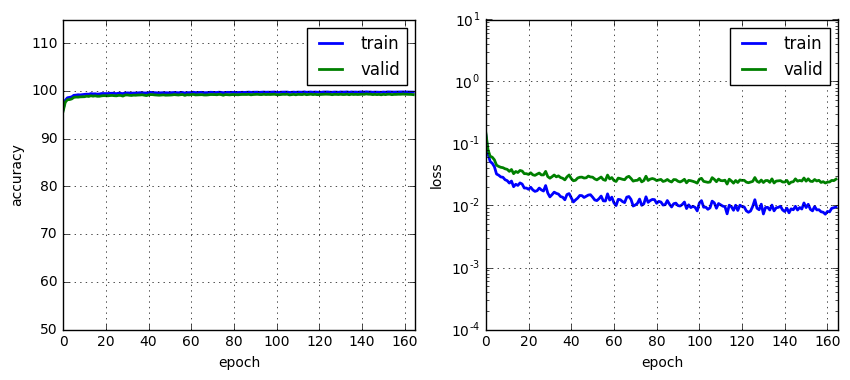

In [328]:
import pickle
import json
from sklearn.model_selection import train_test_split

train_extended_preprocessed_dataset_file = "traffic-signs-data/train_extended_preprocessed.p"
train_balanced_preprocessed_dataset_file = "traffic-signs-data/train_balanced_preprocessed.p"
test_preprocessed_dataset_file = "traffic-signs-data/test_preprocessed.p"

with open(os.path.join(os.getcwd(), 'config.json')) as data_file:    
    logger_config = json.load(data_file)

parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 256,
    max_epochs = 1001,
    log_epoch = 1,
    print_epoch = 1,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 100,
    resume_training = True,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)

X_train, y_train = load_pickled_data(train_balanced_preprocessed_dataset_file, columns = ['features', 'labels'])
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25)
X_test, y_test = load_pickled_data(test_preprocessed_dataset_file, columns = ['features', 'labels'])
train_model(parameters, X_train, y_train, X_valid, y_valid, X_test, y_test, logger_config)

---

## Evaluation

The accuracy of **99.33%** means that there were **85 images** in the test set that this model failed to classify correctly — let's take a look at those 85 images.

In [27]:
def get_top_k_predictions(params, X, k = 5):
    """
    Evaluates `X` on a model defined by `params` and returns top 5 predictions.

    Parameters
    ----------
    params    : Parameters
                Structure (`namedtuple`) containing model parameters.
    X         : 
                Testing dataset. 
    k         : 
                Number of top predictions we are interested in.
                
    Returns
    -------
    An array of top k softmax predictions for each example.
    """
    
    # Initialisation routines: generate variable scope, create logger, note start time.
    paths = Paths(params)
    
    # Build the graph
    graph = tf.Graph()
    with graph.as_default():
        # Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
        tf_x = tf.placeholder(tf.float32, shape = (None, params.image_size[0], params.image_size[1], 1))
        is_training = tf.constant(False)
        with tf.variable_scope(paths.var_scope):
            predictions = tf.nn.softmax(model_pass(tf_x, params, is_training))
            top_k_predictions = tf.nn.top_k(predictions, k)

    with tf.Session(graph = graph) as session:
        session.run(tf.global_variables_initializer())
        tf.train.Saver().restore(session, paths.model_path)
        [p] = session.run([top_k_predictions], feed_dict = {
                tf_x : X
            }
        )
        return np.array(p)

Original:


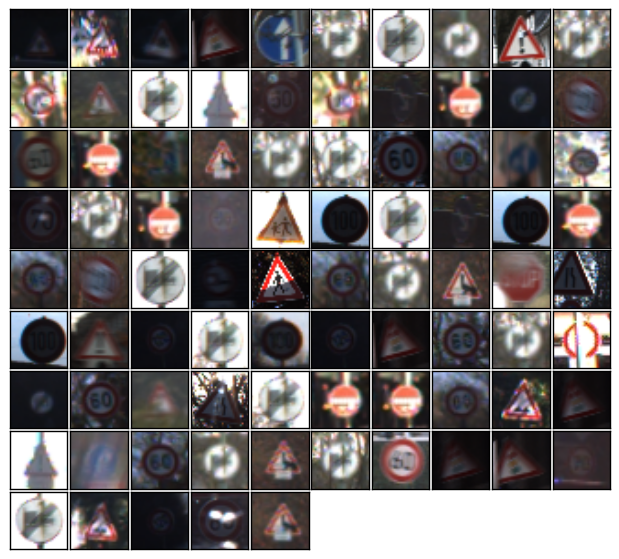

Preprocessed:


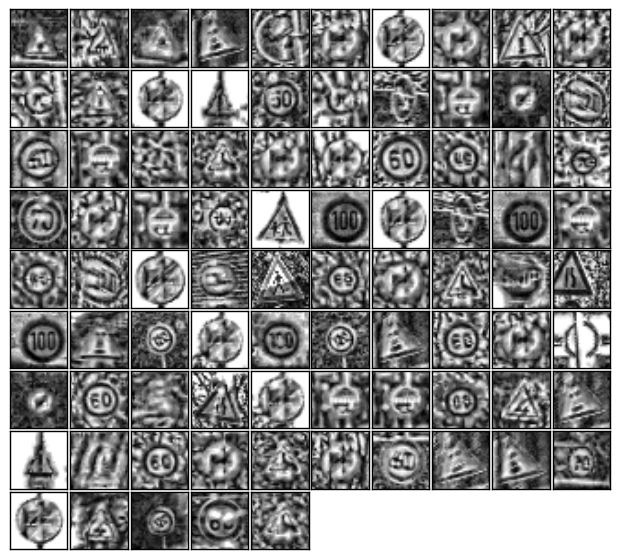

In [28]:
X_test, y_test = load_pickled_data(test_preprocessed_dataset_file, columns = ['features', 'labels'])
X_original, _ = load_pickled_data(test_dataset_file, columns = ['features', 'labels'])
predictions = get_top_k_predictions(parameters, X_test)

predictions = predictions[1][:, np.argmax(predictions[0], 1)][:, 0].astype(int)
labels = np.argmax(y_test, 1)

print("Original:")
incorrectly_predicted = X_original[predictions != labels]
fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(incorrectly_predicted.shape[0]):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(incorrectly_predicted[i])
pyplot.show()

print("Preprocessed:")
incorrectly_predicted = X_test[predictions != labels]
fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(incorrectly_predicted.shape[0]):
    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(incorrectly_predicted[i].reshape(32, 32), cmap='gray')
pyplot.show()

Looks like most of them had artefacts like sunlight or obstructing objects, or didn't have enough data for in the training set. This is one of the issues of training the model on unbalanced data: probably those **100** and **60** signs were incorrectly classified as **80**, as we had significantly more data for those after flipping.

---

### Test a Model on New Images

Try out trained model on manually captured images (in Google Maps). You can find them in `traffic-signs-data/custom/`.

In [41]:
import matplotlib.gridspec as gridspec
from skimage import io
import os

def plot_image_statistics(predictions, index):
    """
    Plots prediction statistics for a single example.

    Parameters
    ----------
    predictions   : 
                    Array of predictions.
    index         : 
                    Index of the example we need to plot statistics for
    """
    # Prepare original and preprocessed images
    original = io.imread(os.getcwd() + '/traffic-signs-data/custom/' + "example_{0:0>5}".format(index + 1) + '.png')
    preprocessed = X_custom[index].reshape(32, 32)
        
    # Prepare the grid
    pyplot.figure(figsize = (6, 2))
    gridspec.GridSpec(2, 2)
    
    # Plot original image
    pyplot.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
    pyplot.imshow(original)
    pyplot.axis('off')

    # Plot preprocessed image
    pyplot.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
    pyplot.imshow(preprocessed, cmap='gray')
    pyplot.axis('off')

    # Plot predictions
    pyplot.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=2)
    pyplot.barh(np.arange(5)+.5, predictions[0][index], align='center')
    pyplot.yticks(np.arange(5)+.5, signnames[predictions[1][index].astype(int)])
    pyplot.tick_params(axis='both', which='both', labelleft='off', labelright='on', labeltop='off', labelbottom='off')
    
    pyplot.show()


train_extended_preprocessed_dataset_file = "traffic-signs-data/train_extended_preprocessed.p"
train_balanced_preprocessed_dataset_file = "traffic-signs-data/train_balanced_preprocessed.p"
test_preprocessed_dataset_file = "traffic-signs-data/test_preprocessed.p"

parameters = Parameters(
    # Data parameters
    num_classes = 43,
    image_size = (32, 32),
    # Training parameters
    batch_size = 256,
    max_epochs = 1001,
    log_epoch = 1,
    print_epoch = 1,
    # Optimisations
    learning_rate_decay = False,
    learning_rate = 0.0001,
    l2_reg_enabled = True,
    l2_lambda = 0.0001,
    early_stopping_enabled = True,
    early_stopping_patience = 100,
    resume_training = True,
    # Layers architecture
    conv1_k = 5, conv1_d = 32, conv1_p = 0.9,
    conv2_k = 5, conv2_d = 64, conv2_p = 0.8,
    conv3_k = 5, conv3_d = 128, conv3_p = 0.7,
    fc4_size = 1024, fc4_p = 0.5
)
    
# Load images from .png files to `X_custom` NumPy array
X_custom = np.empty([0, 32, 32, 3], dtype = np.int32)
for i in range(38):
    image = io.imread(os.getcwd() + '/traffic-signs-data/custom/' + "example_{0:0>5}".format(i + 1) + '.png')
    X_custom = np.append(X_custom, [image[:, :, :3]], axis = 0)

# Provide labels of the captured images:
y_custom = np.array([
    21, # "example_00001"
    39, # "example_00002"
    17, # "example_00003"
    17, # "example_00004"
    17, # "example_00005"
    39, # "example_00006"
    39, # "example_00007"
    40, # "example_00008"
    40, # "example_00009"
    34, # "example_00010"
    28, # "example_00011"
    39, # "example_00012"
    0, # "example_00013"
    17, # "example_00014"
    38, # "example_00015"
    13, # "example_00016"
    40, # "example_00017"
    13, # "example_00018"
    38, # "example_00019"
    38, # "example_00020"
    11, # "example_00021"
    0, # "example_00022"
    28, # "example_00023"
    0, # "example_00024"
    99, # "example_00025"
    99, # "example_00026"
    99, # "example_00027"
    32, # "example_00028"
    40, # "example_00029"
    28, # "example_00030"
    40, # "example_00031"
    40, # "example_00032"
    28, # "example_00033"
    24, # "example_00034"
    0, # "example_00035"
    0, # "example_00036"
    0, # "example_00037"
    0 # "example_00038"
])

# Preprocess and get predictions based on the current model
X_custom, _ = preprocess_dataset(X_custom)
predictions = get_top_k_predictions(parameters, X_custom)

Preprocessing dataset with 38 examples:
 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100%


Actual class:  Double curve


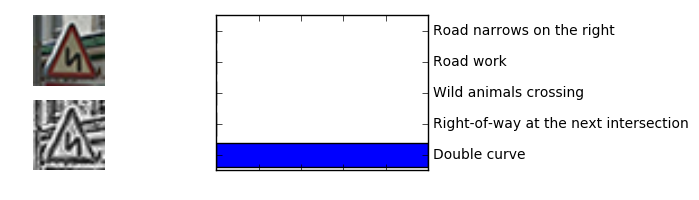

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


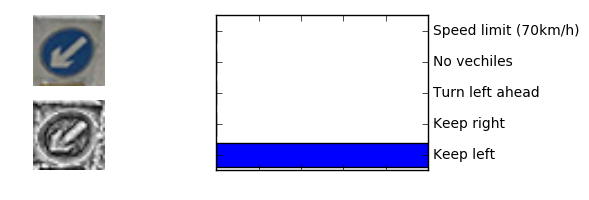

---------------------------------------------------------------------------------------------------

Actual class:  No entry


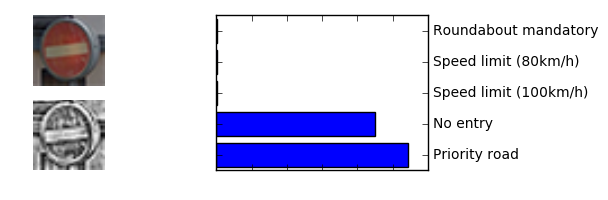

---------------------------------------------------------------------------------------------------

Actual class:  No entry


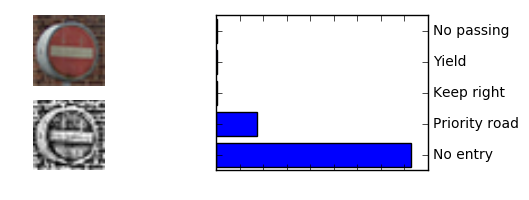

---------------------------------------------------------------------------------------------------

Actual class:  No entry


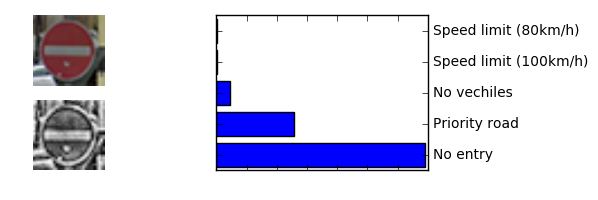

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


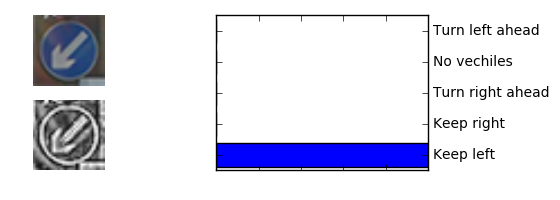

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


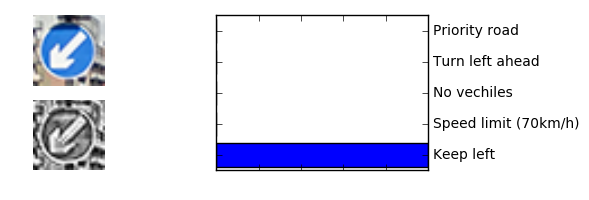

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


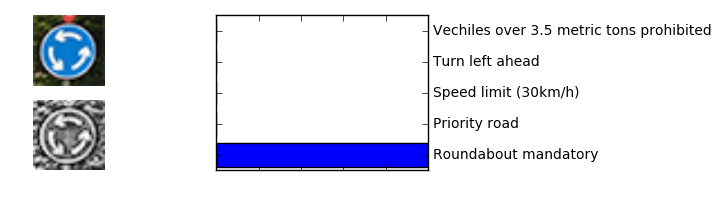

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


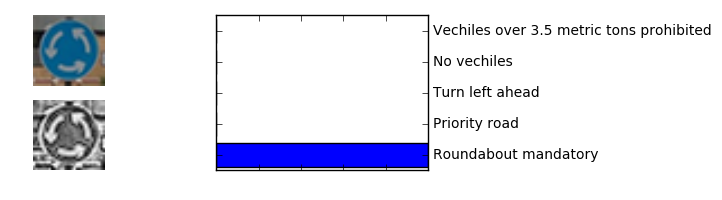

---------------------------------------------------------------------------------------------------

Actual class:  Turn left ahead


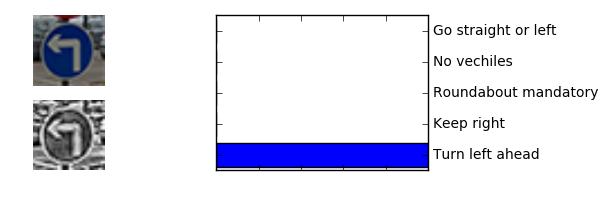

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


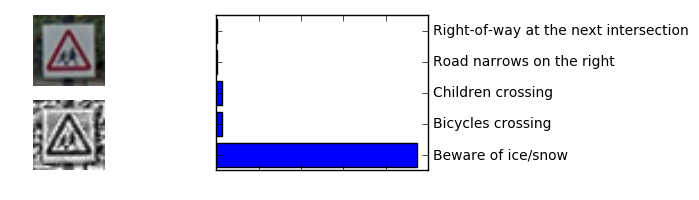

---------------------------------------------------------------------------------------------------

Actual class:  Keep left


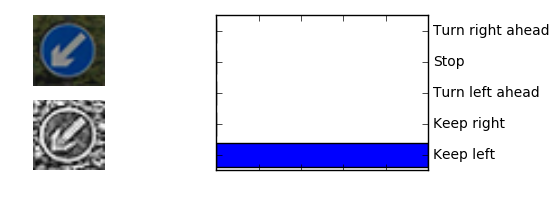

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


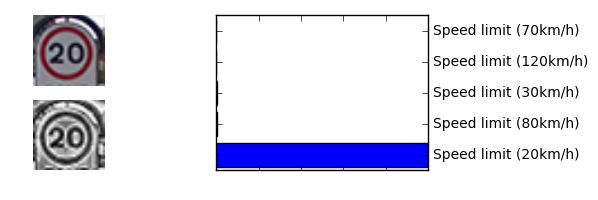

---------------------------------------------------------------------------------------------------

Actual class:  No entry


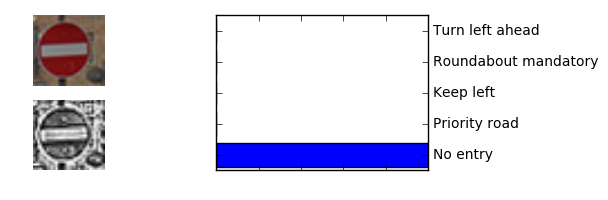

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


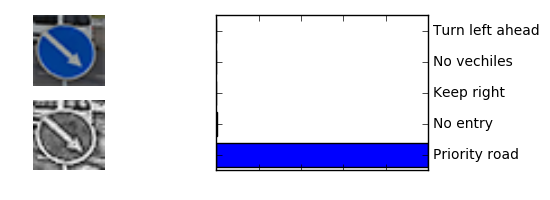

---------------------------------------------------------------------------------------------------

Actual class:  Yield


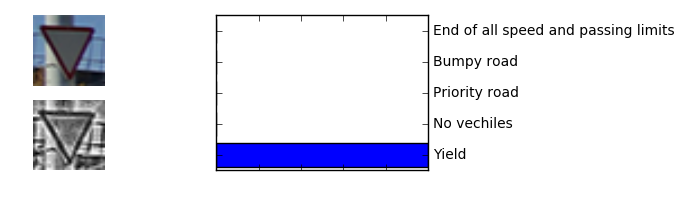

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


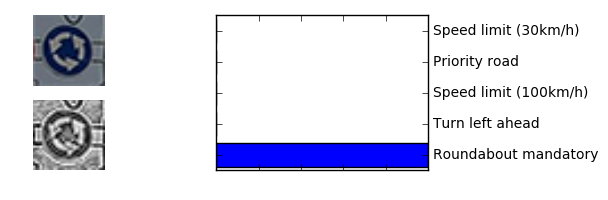

---------------------------------------------------------------------------------------------------

Actual class:  Yield


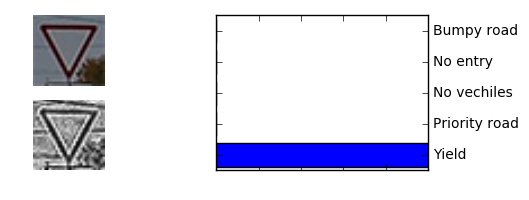

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


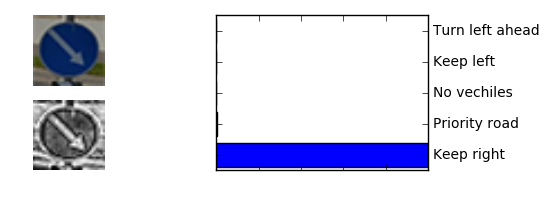

---------------------------------------------------------------------------------------------------

Actual class:  Keep right


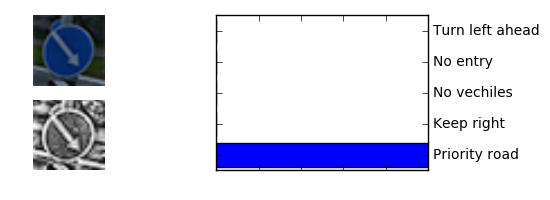

---------------------------------------------------------------------------------------------------

Actual class:  Right-of-way at the next intersection


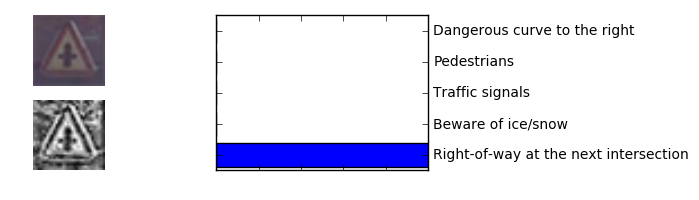

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


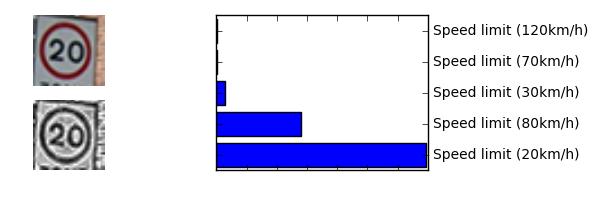

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


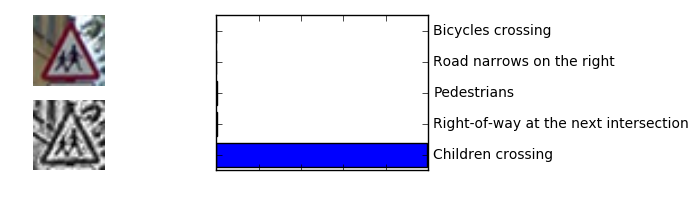

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


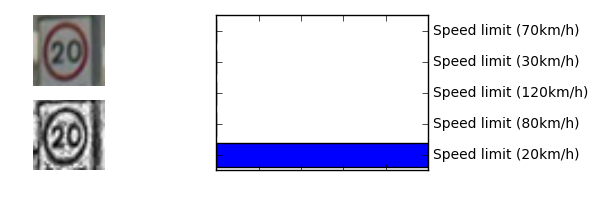

---------------------------------------------------------------------------------------------------

Actual class:  None


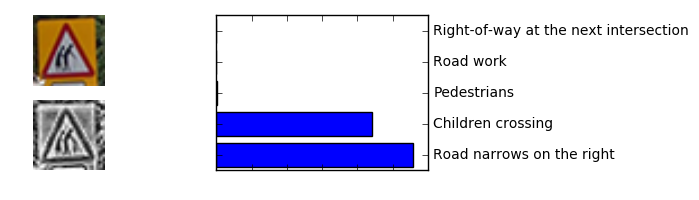

---------------------------------------------------------------------------------------------------

Actual class:  None


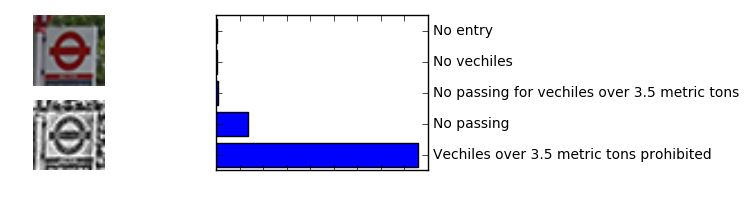

---------------------------------------------------------------------------------------------------

Actual class:  None


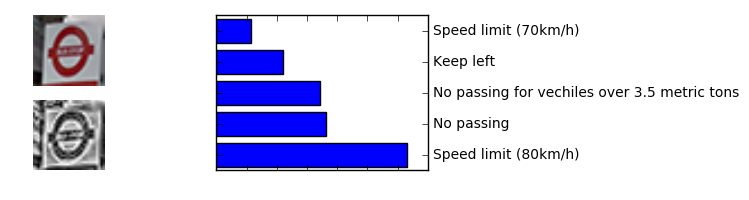

---------------------------------------------------------------------------------------------------

Actual class:  End of all speed and passing limits


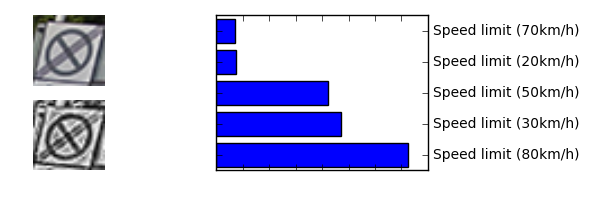

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


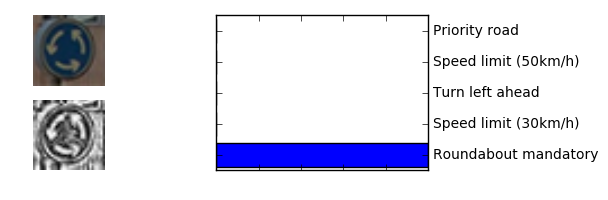

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


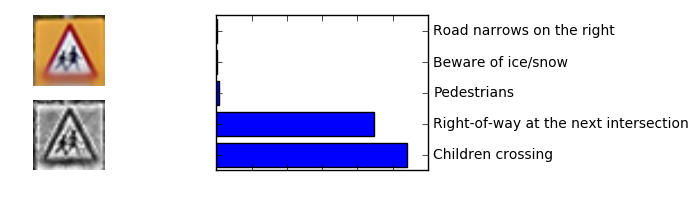

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


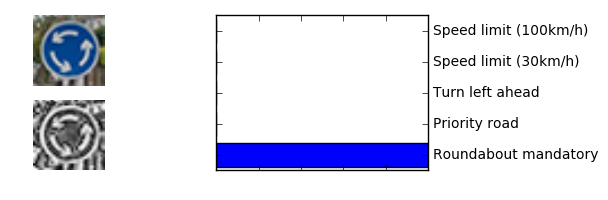

---------------------------------------------------------------------------------------------------

Actual class:  Roundabout mandatory


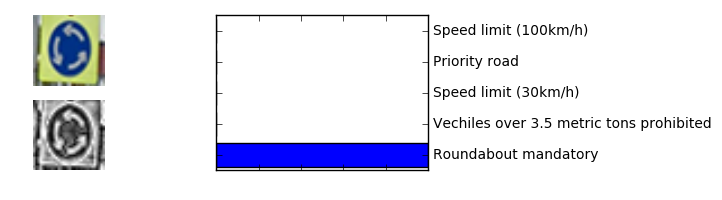

---------------------------------------------------------------------------------------------------

Actual class:  Children crossing


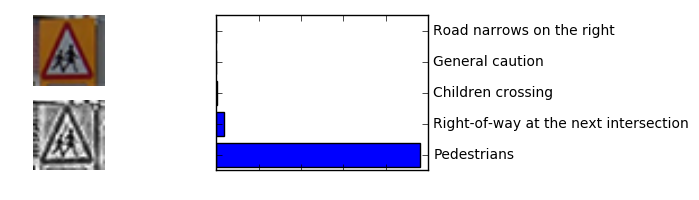

---------------------------------------------------------------------------------------------------

Actual class:  Road narrows on the right


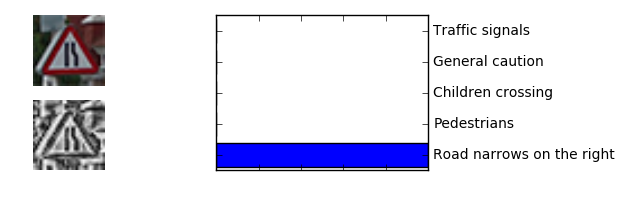

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


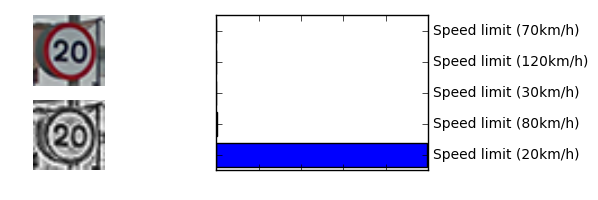

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


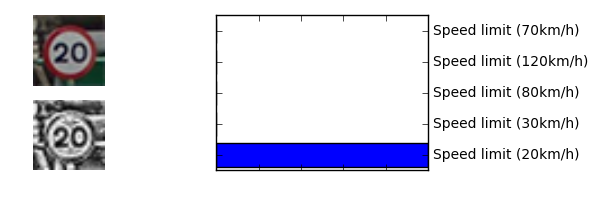

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


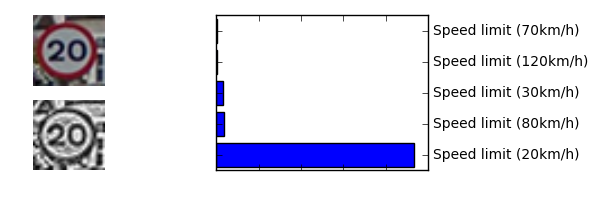

---------------------------------------------------------------------------------------------------

Actual class:  Speed limit (20km/h)


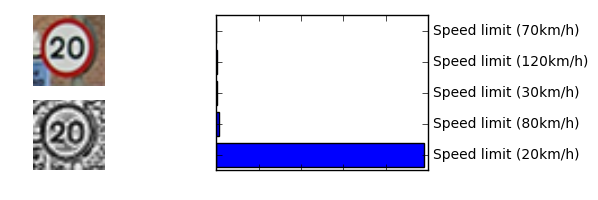

---------------------------------------------------------------------------------------------------



In [45]:
# For every example plot original image, preprocessed image, and model predictions.
for i in range(38):
    print("Actual class: ", signnames[y_custom[i]] if y_custom[i] != 99 else "None")
    plot_image_statistics(predictions, i)
    print("---------------------------------------------------------------------------------------------------\n")

Surprisingly, the model was quite sure about some of the false predictions. My best guesses are:
* These last two signs look fairly different from the German ones. 
* First training stage was carried out on a **extended** dataset and not **balanced** one, the model became biased towards predicting overrepresented classes — such as **Priority road**.

Unfortunately this model kind of overfits the supplied test data (although I didn't use it while training, of course), as my main goal was to **get highest score** on the supplied testing set. If I were to implement the model that should **perform best on arbitrary captured dataset**, I would only train it on class-balanced data, where all classes were equally represented. However, since the goal was to get highest test set accuracy, it may be overfitting it a bit.

I am confident I could improve performance of this model even further with a couple of other interesting ideas I had, but I'm already a couple of days late with the submission due date, so I decided to call it a day.

In [40]:
# Remove examples of unseen classes, like "Elderly Crossing" and preprocess y:
X_custom = X_custom[y_custom < 99]
y_custom = y_custom[y_custom < 99]
y_custom = np.eye(43)[y_custom]

predictions = get_predictions(parameters, X_custom)[1][:, 0]
accuracy = 100.0 * np.sum(predictions == np.argmax(y_custom, 1)) / predictions.shape[0]
print("Accuracy on captured images: %.2f%%" % (accuracy)) 

Accuracy on captured images: 82.86%


Accuracy on the captured images was **82.86%** for this model. It could be higher if I only used German-looking signs — however as indicated earlier I used a mixture of UK and non-EU signs, some of them looked fairly different from the German ones, hence the low accuracy.